In [ ]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow import keras
import tensorflow as tf
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import os
import scipy.io as sio
import xgboost as xgb
import glob
import imageio
import numpy as np
import os
import PIL
import time
from IPython import display

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, regularizers
#rom torch_two_sample.statistics_diff import MMDStatistic
import torch

import matplotlib.pyplot as plt
import numpy as np
import random

from IPython import display
from tqdm import tqdm
from shutil import copyfile

In [184]:
sr = 100

In [186]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    #path = r"c:\Users\Barre\Downloads\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [187]:

with tf.device('/GPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        y_train = pd.get_dummies(y_train)

        y_train = y_train.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89) & (y_train >= 75)] # Additional filtering of patients older than 89 and younger than 18
        ry_train = y_train[(y_train < 89) & (y_train >= 75)]

        if(shape == True):
            print((X_train.shape, y_train.shape))

        return rX_train, ry_train
    
    X_train, y_train = tvt_split(X, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,))


In [189]:
len(y_train)

3253

In [ ]:
def make_teset(X_train, y_train):
    X_test = X_train[0:100]
    X_train = X_train[-0:100]

    y_test = y_train[0:100]
    y_train = y_train[-0:100]
    return y_test,X_test
make_teset(X_train=X_train, y_train=y_train)

In [237]:
def test_show(generator, discriminator):
    noise = tf.random.normal([64, 1000, 12])
    generated_ecg = generator(noise, training=False)
    print(generated_ecg.shape)
    plt.plot(generated_ecg[0, 0, :])
    plt.show()
    
    decision = discriminator(generated_ecg, training=False)
    print(decision)
norm_value = 2173

def generate_and_save_ecg(model, epoch, test_input, save):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,3))
    plt.plot(predictions[0, 0, :] * norm_value)
    # plt.plot(predictions[0, 0, :])
    
    if save:
        plt.savefig('./ecg_at_epoch_{:04d}.png'.format(epoch))

    plt.show()


In [238]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(1000, 12)))

    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))

    model.add(layers.Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
  
    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1D(filters=16, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=1, kernel_size=16, strides=1, padding='same', activation='tanh'))
    
    model.add(layers.Permute((2, 1)))
    
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
   
    model.add(layers.Input(shape=(1, 400)))
    model.add(layers.Permute((2, 1)))
    
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    model.add(layers.Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=256, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator     = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()
discriminator.summary()

# test_show(generator, discriminator)


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_17 (Bidirecti  (None, 1000, 128)        39424     
 onal)                                                           
                                                                 
 conv1d_141 (Conv1D)         (None, 1000, 128)         262272    
                                                                 
 leaky_re_lu_156 (LeakyReLU)  (None, 1000, 128)        0         
                                                                 
 conv1d_142 (Conv1D)         (None, 1000, 64)          131136    
                                                                 
 leaky_re_lu_157 (LeakyReLU)  (None, 1000, 64)         0         
                                                                 
 up_sampling1d_34 (UpSamplin  (None, 2000, 64)         0         
 g1D)                                                

In [239]:
disc_losses = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
disc_losses_list = []

### discriminator accuracy ###
fake_disc_accuracy = tf.keras.metrics.BinaryAccuracy('fake_disc_accuracy')
real_disc_accuracy = tf.keras.metrics.BinaryAccuracy('real_disc_accuracy')
fake_disc_accuracy_list, real_disc_accuracy_list = [], []

### generator loss ###
# gen_log_dir = 'logs/gradient_tape/gen_loss'
# gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
gen_losses = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
gen_losses_list = []


#################################################################################
#          Prepare loss functions and optimizers
#################################################################################

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

In [240]:
disc_steps = 1

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_ecg, dim):
    noise = tf.random.normal(((1,64), 1000, 12))
    for i in range(disc_steps):
        with tf.GradientTape() as disc_tape:
            generated_ecg = generator(noise, training=True)

            real_output = discriminator(real_ecg, training=True)
            fake_output = discriminator(generated_ecg, training=True)

            disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        ### for tensorboard ###
        disc_losses.update_state(disc_loss)
        fake_disc_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
        real_disc_accuracy.update_state(tf.ones_like(real_output), real_output)
        #######################
    
    with tf.GradientTape() as gen_tape:
        generated_ecg = generator(noise, training=True)
        fake_output = discriminator(generated_ecg, training=True)

        gen_loss = generator_loss(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    ### for tensorboard ###
    gen_losses.update_state(gen_loss)
    #######################
    

def train(dataset, epochs, dim):
    for epoch in tqdm(range(epochs)):
    
        for batch in dataset:
            train_step(64, dim)
            
        disc_losses_list.append(disc_losses.result().numpy())
        gen_losses_list.append(gen_losses.result().numpy())
        
        fake_disc_accuracy_list.append(fake_disc_accuracy.result().numpy())
        real_disc_accuracy_list.append(real_disc_accuracy.result().numpy())
        
        ### for tensorboard ###
#         with disc_summary_writer.as_default():
#             tf.summary.scalar('loss', disc_losses.result(), step=epoch)
#             tf.summary.scalar('fake_accuracy', fake_disc_accuracy.result(), step=epoch)
#             tf.summary.scalar('real_accuracy', real_disc_accuracy.result(), step=epoch)
            
#         with gen_summary_writer.as_default():
#             tf.summary.scalar('loss', gen_losses.result(), step=epoch)
            
        disc_losses.reset_states()        
        gen_losses.reset_states()
        
        fake_disc_accuracy.reset_states()
        real_disc_accuracy.reset_states()
        #######################

        # Save the model every 5 epochs
#         if (epoch + 1) % 5 == 0:
#             generate_and_save_ecg(generator, epochs, seed, False)
#             checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_ecg(generator, epochs, seed, False)

In [241]:
noise_dim = [BATCH_SIZE, 1000, 12]

X_train.shape

(3253, 1000, 12)

In [242]:
def prepare_data(dim):
    # Load and preprocess your data here
    data = X_train  # Assuming X_train has shape (3253, 1000, 12)

    print('Data shape:', data.shape)

    # Normalize the data
    data = data / norm_value
    data = np.array(data, dtype='float32')

    plt.figure(figsize=(4, 3))
    plt.plot(data[random.randint(0, data.shape[0])][0] * norm_value)
    plt.show()

    train_size = int(data.shape[0] * 0.9)
    test_size = data.shape[0] - train_size
    print(train_size, test_size)

    # Shuffle and batch the data (no need to reshape the datasets)
    train_dataset = tf.data.Dataset.from_tensor_slices(data[:train_size]).shuffle(train_size).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices(data[train_size:]).shuffle(test_size).batch(1)

    seed = tf.random.normal(dim)

    return seed, train_dataset, test_dataset


Data shape: (3253, 1000, 12)


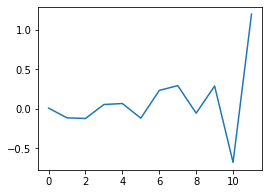

2927 326


In [243]:
BATCH_SIZE = 64
noise_dim = [BATCH_SIZE, 100, 12]

seed, train_dataset, test_dataset = prepare_data(noise_dim)

In [244]:
train(train_dataset, 5, noise_dim)


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\Barre\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\tensor_util.py:455: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nparray = np.array(values, dtype=np_dt)
  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: in user code:

    File "C:\Users\Barre\AppData\Local\Temp/ipykernel_13064/1608427266.py", line 7, in train_step  *
        noise = tf.random.normal(((1,64), 1000, 12))

    ValueError: Expected values ((1, 64), 1000, 12) to be a dense tensor with shape [3, 2], but got shape [3].


In [ ]:

fig, axes = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Losses", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].plot(disc_losses_list, color='red')
axes[0].plot(gen_losses_list, color='blue')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(fake_disc_accuracy_list, color='red')
axes[1].plot(real_disc_accuracy_list, color='blue')
plt.show()

In [ ]:
seed = tf.random.normal(noise_dim)
ecg = generator(seed, training=False)
answer = discriminator(ecg)
fig = plt.figure(figsize=(4,3))
plt.plot(ecg[0, 0, :] * norm_value)
plt.show()
print(answer[0])

In [ ]:
generator.save(r'C:\Users\Barre\Downloads\gen_ecg.h5')
discriminator.save(r"C:\Users\Barre\Downloads\dis_ecg.h5")

In [ ]:
model = tf.keras.models.load_model('gen_ecg.h5')


In [ ]:
model.summary()


In [ ]:
seed = tf.random.normal([1, 100, 12])
ecg = model(seed, training=False)
fig = plt.figure(figsize=(4,3))
plt.plot(ecg[0, 0, :] * norm_value)
plt.show()

In [ ]:
def rmse(targets, predictions):
    return np.sqrt(np.mean((targets-predictions)**2))


def prd(targets, predictions):
    s1 = np.sum((targets-predictions)**2)
    s2 = np.sum(targets**2)
    return np.sqrt(s1 / s2 * 100)


def mmd(targets, predictions):
    mmd_stat = MMDStatistic(400, 400)
    sample_target = torch.from_numpy(targets.numpy().reshape((400,1)))
    sample_pred = torch.from_numpy(predictions.numpy().reshape((400,1)))
    
    stat = mmd_stat(sample_target, sample_pred, [1.])
    return(stat.item())


def testing(test_dataset, model, noise_dim):
    noise = tf.random.normal(noise_dim)
    generated_ecgs = model(noise, training=False)

    mmd_sum, prd_sum, rmse_sum = [], [], []
    for true_ecg, gen_ecg in zip(test_dataset, generated_ecgs):
        prd_sum.append(prd(true_ecg[0][0], gen_ecg[0]))
        rmse_sum.append(rmse(true_ecg[0][0], gen_ecg[0]))
        mmd_sum.append(mmd(true_ecg[0][0], gen_ecg[0]))

    print('mmd :', f'mean={np.mean(mmd_sum):.6f}', f'min={np.min(mmd_sum):.6f}', f'max={np.max(mmd_sum):.6f}')
    print('prd :', f'mean={np.mean(prd_sum):.4f}', f'min={np.min(prd_sum):.4f}', f'max={np.max(prd_sum):.4f}')
    print('rmse:', f'mean={np.mean(rmse_sum):.4f}', f'min={np.min(rmse_sum):.4f}', f'max={np.max(rmse_sum):.4f}')
